# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.306077
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** The outcome should be purely random with a probility(p) 0.1 for each class. And the loss is -log(p). 


In [67]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.947358 analytic: -0.947358, relative error: 2.518258e-09
numerical: 1.430046 analytic: 1.430046, relative error: 3.196910e-08
numerical: 1.718931 analytic: 1.718931, relative error: 3.196829e-08
numerical: 0.069011 analytic: 0.069011, relative error: 9.873659e-07
numerical: 3.409790 analytic: 3.409789, relative error: 2.796571e-08
numerical: 3.453243 analytic: 3.453243, relative error: 1.736656e-08
numerical: 3.607126 analytic: 3.607126, relative error: 7.263176e-09
numerical: -0.081090 analytic: -0.081090, relative error: 3.239215e-07
numerical: 3.869423 analytic: 3.869423, relative error: 4.739233e-09
numerical: 0.790016 analytic: 0.790016, relative error: 5.585621e-08
numerical: -3.273818 analytic: -3.273818, relative error: 6.346525e-09
numerical: -1.603008 analytic: -1.603008, relative error: 1.641494e-08
numerical: 1.605788 analytic: 1.605788, relative error: 5.681326e-08
numerical: 0.857659 analytic: 0.857659, relative error: 2.912652e-08
numerical: 1.224881 analyt

In [68]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.306077e+00 computed in 0.169009s
vectorized loss: 2.306077e+00 computed in 0.005000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [49]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for count in range(100):
    
    lr = 10 **np.random.uniform(-7, -5)
    reg = 10 **np.random.uniform(2, 5)

    softmax = Softmax()
    softmax.train(X_train, y_train, lr, reg)
    train_pred = softmax.predict(X_train)
    train_acc = np.mean(y_train == train_pred)
    val_pred = softmax.predict(X_val)
    val_acc = np.mean(y_val == val_pred)
    results[(lr, reg)] = val_acc
    if val_acc > best_val:
        best_val = val_acc
        best_softmax = softmax

    print('lr %e reg %e train accuracy: %f val accuracy: %f best value: %f' % 
          (lr, reg, train_acc, val_acc, best_val))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 9.478941e-07 reg 2.018048e+02 train accuracy: 0.222551 val accuracy: 0.217000 best value: 0.217000
lr 8.748969e-07 reg 6.259074e+03 train accuracy: 0.257082 val accuracy: 0.270000 best value: 0.270000
lr 1.782973e-07 reg 1.922466e+04 train accuracy: 0.156204 val accuracy: 0.154000 best value: 0.270000
lr 6.440546e-07 reg 4.326790e+02 train accuracy: 0.221633 val accuracy: 0.221000 best value: 0.270000
lr 8.997606e-06 reg 3.273137e+03 train accuracy: 0.247102 val accuracy: 0.259000 best value: 0.270000
lr 1.108628e-07 reg 2.030939e+02 train accuracy: 0.156735 val accuracy: 0.174000 best value: 0.270000
lr 2.621810e-06 reg 4.778253e+03 train accuracy: 0.327265 val accuracy: 0.345000 best value: 0.345000
lr 4.399421e-07 reg 2.813046e+03 train accuracy: 0.203918 val accuracy: 0.227000 best value: 0.345000
lr 9.401613e-06 reg 1.257727e+02 train accuracy: 0.295102 val accuracy: 0.311000 best value: 0.345000
lr 6.861126e-06 reg 2.790329e+03 train accuracy: 0.285367 val accuracy: 0.298000 b

lr 3.629909e-06 reg 5.938008e+02 train accuracy: 0.296694 val accuracy: 0.334000 best value: 0.370000
lr 6.689042e-06 reg 1.139192e+04 train accuracy: 0.263367 val accuracy: 0.279000 best value: 0.370000
lr 2.028547e-07 reg 2.640930e+02 train accuracy: 0.161571 val accuracy: 0.167000 best value: 0.370000
lr 2.455263e-06 reg 3.253676e+04 train accuracy: 0.285306 val accuracy: 0.287000 best value: 0.370000
lr 4.256411e-06 reg 9.979138e+04 train accuracy: 0.226041 val accuracy: 0.238000 best value: 0.370000
lr 1.481171e-07 reg 6.902506e+02 train accuracy: 0.155531 val accuracy: 0.156000 best value: 0.370000
lr 2.003932e-07 reg 7.306561e+04 train accuracy: 0.225776 val accuracy: 0.244000 best value: 0.370000
lr 1.313601e-07 reg 1.862156e+03 train accuracy: 0.141469 val accuracy: 0.147000 best value: 0.370000
lr 3.578697e-06 reg 1.412816e+02 train accuracy: 0.286633 val accuracy: 0.292000 best value: 0.370000
lr 1.718570e-06 reg 1.697454e+03 train accuracy: 0.272571 val accuracy: 0.283000 b

Text(0.5,1,'validation accuracy')

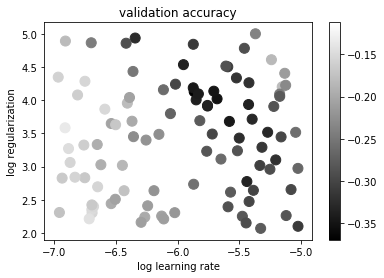

In [50]:
# Visualize the cross-validation results
import math
plt.rcParams['image.cmap'] = 'gray'

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot validation accuracy
marker_size = 100
colors = [-results[x] for x in results] 
plt.scatter(x_scatter, y_scatter, 100, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization')
plt.title('validation accuracy')

In [51]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.351000


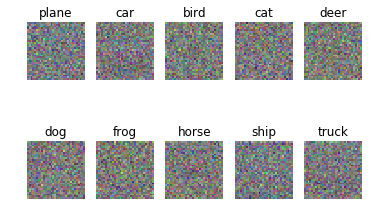

In [52]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])